## MNIST CNN

In [1]:
%matplotlib inline

In [2]:
from fastai.vision.all import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

(#2) [Path('/home/sandmann18/.fastai/data/mnist_png/training'),Path('/home/sandmann18/.fastai/data/mnist_png/testing')]

In [5]:
items = get_image_files(path)
items[0]

Path('/home/sandmann18/.fastai/data/mnist_png/training/4/47823.png')

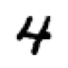

In [6]:
im = PILImageBW.create(items[0])
im.show();

In [7]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')(items)

In [8]:
dsets = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=splits)

In [9]:
dsets

(#70000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

In [10]:
dsets.train

(#60000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

In [11]:
dsets.valid

(#10000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

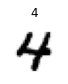

In [12]:
show_at(dsets.train, 0);

In [13]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]
bs = 128

In [15]:
dls = dsets.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor, Normalize()])

In [22]:
dsrc1 = Datasets([items[0]]*128, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=[list(range(128)), []])

In [23]:
dbunch1 = dsrc1.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor])

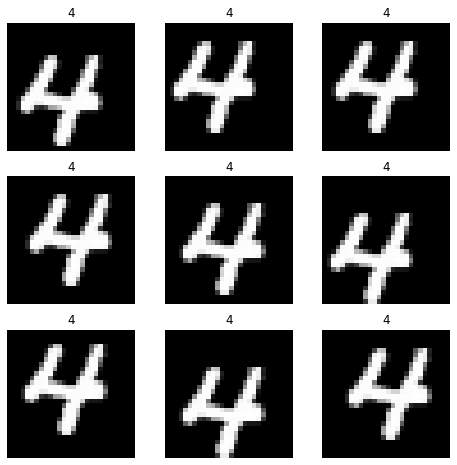

In [24]:
dbunch1.show_batch(figsize=(8,8), cmap='gray')

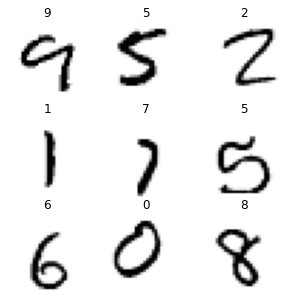

In [25]:
dls.show_batch(figsize=(5,5))

In [26]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

### Basic CNN with batchnorm

In [ ]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [ ]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

In [ ]:
xb = xb.cuda()

In [ ]:
model(xb).shape

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.fit_one_cycle(3, lr_max=0.1)

### Refactor

In [ ]:
def conv2(ni,nf): return ConvLayer(ni,nf,stride=2)

In [ ]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, lr_max=0.1)

### Resnet-ish

In [ ]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf,nf)
        self.conv2 = ConvLayer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
model = nn.Sequential(
    conv2(1, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.fit_one_cycle(12, lr_max=0.05)

In [ ]:
print(learn.summary())

## fin